In [146]:
import pandas as pd
import xmltodict
import zipfile
import numpy as np
from matplotlib.dates import DateFormatter
import seaborn as sns

In [147]:
import zipfile
import pandas as pd
import xmltodict

def new_data_parsing(zip_path:str = 'export.zip' ,save_csv_path:str = 'health_data.csv', save:bool = True) -> pd.DataFrame:
    """
    This function performs the following steps in an Apple Health export
    Unzip, parse xml and save as a csv file

    :param zip_path: the path to your export zip file
    :param save_csv_path: the path to save your csv. Must end in .csv
    :param save: Bool to determine if you wish to save the csv or just return it
    :return: Returns a data frame containing the parsed health data
    """

    ## Extracting zip
    with zipfile.ZipFile(zip_path,"r") as zip_ref:
        zip_ref.extractall()

    ## Parsing xml
    input_path = 'apple_health_export/export.xml'
    with open(input_path, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())

    ## Selecting only relevant dict keys
    records_list = input_data['HealthData']['Record']

    ## Creating and saving csv
    df = pd.DataFrame(records_list)
    if save:
        df.to_csv(save_csv_path,index=False, sep=';')

    return df

In [148]:
data = pd.read_csv('health_data.csv',sep=';')

C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_24112\3679158665.py:1: DtypeWarning: Columns (7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('health_data.csv',sep=';')


In [149]:
data.head()

,@type,@sourceName,@sourceVersion,@unit,@creationDate,@startDate,@endDate,@value,MetadataEntry,@device,HeartRateVariabilityMetadataList
0,HKQuantityTypeIdentifierDietaryWater,Lifesum,2,mL,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,2020-12-05 02:07:11 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
1,HKQuantityTypeIdentifierDietaryWater,Lifesum,3,mL,2020-06-16 16:07:10 -0300,2020-06-16 16:07:09 -0300,2020-06-16 16:07:09 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
2,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-17 15:55:43 -0300,2020-06-17 15:55:42 -0300,2020-06-17 15:55:42 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
3,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,2020-06-19 20:02:19 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN
4,HKQuantityTypeIdentifierDietaryWater,Lifesum,1,mL,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,2020-06-27 15:30:24 -0300,0.0,"[OrderedDict([('@key', 'HKMetadataKeySyncVersi...",NaN,NaN


In [150]:
data['@type'].value_counts()

HKQuantityTypeIdentifierActiveEnergyBurned                1430914
HKQuantityTypeIdentifierHeartRate                          343706
HKQuantityTypeIdentifierBasalEnergyBurned                  320805
HKQuantityTypeIdentifierDistanceWalkingRunning             274731
HKQuantityTypeIdentifierStepCount                          262952
HKQuantityTypeIdentifierAppleExerciseTime                   46910
HKQuantityTypeIdentifierAppleStandTime                      37852
HKCategoryTypeIdentifierAppleStandHour                      26889
HKQuantityTypeIdentifierEnvironmentalAudioExposure          22457
HKQuantityTypeIdentifierWalkingSpeed                         8961
HKQuantityTypeIdentifierWalkingStepLength                    8949
HKQuantityTypeIdentifierFlightsClimbed                       8477
HKQuantityTypeIdentifierWalkingDoubleSupportPercentage       6846
HKQuantityTypeIdentifierHeadphoneAudioExposure               4313
HKCategoryTypeIdentifierSleepAnalysis                        3897
HKQuantity

In [151]:
data.dtypes

@type                               object
@sourceName                         object
@sourceVersion                      object
@unit                               object
@creationDate                       object
@startDate                          object
@endDate                            object
@value                              object
MetadataEntry                       object
@device                             object
HeartRateVariabilityMetadataList    object
dtype: object

In [152]:
data['@sourceName'].value_counts()

AppleÂ Watch de Gabriel        2233261
Gabrielâ€™s AppleÂ Watch        425216
iPhone de Gabriel Cassimiro     159725
AutoSleep                         1368
Lifesum                           1347
Forest                             158
Clock                              146
Renpho                             124
Headspace                           33
Health                               4
Name: @sourceName, dtype: int64

In [153]:
def data_preprocessing(df: pd.DataFrame, health_data_type: str) -> pd.DataFrame:
    """
    Preprocess data frame fixing dates, data types and grouping by day.

    :param df: the data frame to be processed
    :param health_data_type: @type id in the health database
    :return: preprocessed data frame
    """

    ## Filtering selected @type
    df = df[df['@type'] == health_data_type]

    ## Transform dates to DateTime format
    df['date'] = pd.to_datetime(df['@startDate'],
                                          format='%Y-%m-%d %H:%M:%S %z',)
    ## Transform values to float
    df['@value'] =df['@value'].astype('float')


    ## return grouped values for Burned Energy for each day
    return df.groupby(pd.Grouper(key='date', freq='D'))['@value'].sum().reset_index()

df = data_preprocessing(data,'HKQuantityTypeIdentifierAppleExerciseTime')

C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_24112\2769948671.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['@startDate'],
C:\Users\gabrielcassimiro\AppData\Local\Temp\ipykernel_24112\2769948671.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['@value'] =df['@value'].astype('float')


In [154]:
df.head()

,date,@value
0,2017-09-25 00:00:00-03:00,40.0
1,2017-09-26 00:00:00-03:00,54.0
2,2017-09-27 00:00:00-03:00,47.0
3,2017-09-28 00:00:00-03:00,13.0
4,2017-09-29 00:00:00-03:00,42.0


In [155]:
df.dtypes

date      datetime64[ns, pytz.FixedOffset(-180)]
@value                                   float64
dtype: object

In [156]:
df.isna().sum()

date      0
@value    0
dtype: int64

In [157]:
(df['@value'] == 0).sum()

167

In [158]:
(df['@value'] <= 7).sum()

528

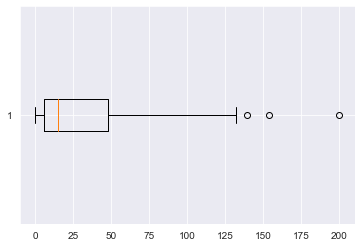

In [159]:
import matplotlib.pyplot as plt

plt.boxplot(df['@value'], vert=False,whis=2)
plt.savefig('box_plot.png', transparent=True)

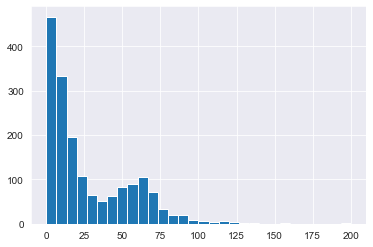

In [190]:
plt.hist(df['@value'],bins=30)
plt.savefig('histogram.png', transparent=True)
# plt.show()

In [161]:
print(pd.date_range(start=df.date.min(), end=df.date.max()).difference(df.set_index('date').index))

DatetimeIndex([], dtype='datetime64[ns, pytz.FixedOffset(-180)]', freq='D')


In [162]:
print(df.date.min(),df.date.max())

2017-09-25 00:00:00-03:00 2022-06-27 00:00:00-03:00


In [163]:
df.shape

(1737, 2)

In [164]:
df

,date,@value
0,2017-09-25 00:00:00-03:00,40.0
1,2017-09-26 00:00:00-03:00,54.0
2,2017-09-27 00:00:00-03:00,47.0
3,2017-09-28 00:00:00-03:00,13.0
4,2017-09-29 00:00:00-03:00,42.0
...,...,...
1732,2022-06-23 00:00:00-03:00,99.0
1733,2022-06-24 00:00:00-03:00,96.0
1734,2022-06-25 00:00:00-03:00,19.0
1735,2022-06-26 00:00:00-03:00,66.0


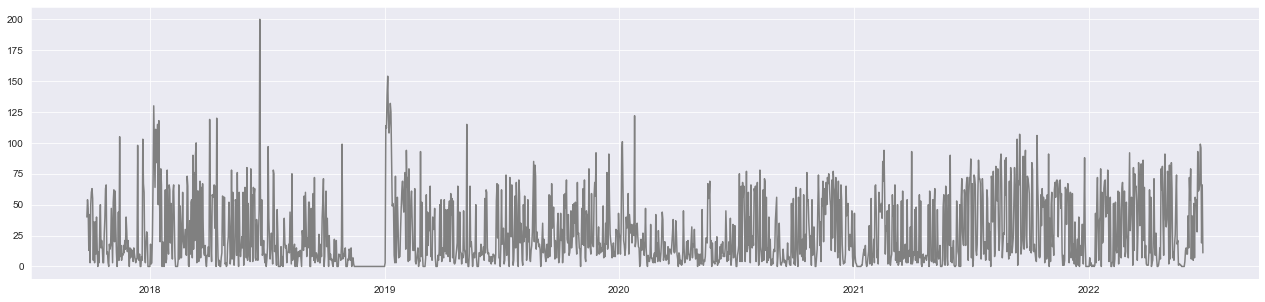

In [176]:
date_form = DateFormatter("%d-%b")

fig, ax = plt.subplots(figsize=(22, 5))
plt.plot(df.date,df['@value'], label='Real', color='gray')

In [166]:
df

,date,@value
0,2017-09-25 00:00:00-03:00,40.0
1,2017-09-26 00:00:00-03:00,54.0
2,2017-09-27 00:00:00-03:00,47.0
3,2017-09-28 00:00:00-03:00,13.0
4,2017-09-29 00:00:00-03:00,42.0
...,...,...
1732,2022-06-23 00:00:00-03:00,99.0
1733,2022-06-24 00:00:00-03:00,96.0
1734,2022-06-25 00:00:00-03:00,19.0
1735,2022-06-26 00:00:00-03:00,66.0


In [167]:
def feature_engineering(df: pd.DataFrame, target_name: str) -> pd.DataFrame:
    """
    Creates these features:
    Date attributes (day, weekday, month, year, season)
    Lag features (how many calories were spent in the last period)
    Rolling Window features (moving average, standard deviation, max, min)

    :param target_name: Column name with the target data
    :param df: Data frame with the target column and a date column
    :return: Original dataframe with new columns
    """
    ## Time related features
    shift_df = df[target_name]
    for lag in [1, 2, 7, 14]:
        df[f"lag_{lag}"] = shift_df.shift(lag).values

    for window in [1, 2, 7, 14, 28]:
        for agg in ['mean', 'min', 'max','std']:
            df[f"r{agg}_1_{window}"] = shift_df.shift(1).rolling(window).agg(agg).values

    ## Date features
    df['day'] = df.date.dt.day
    df['weekday'] = df.date.dt.weekday ##Monday=0 and Sunday=6
    df['month'] = df.date.dt.month
    df['year'] = df.date.dt.year


    # Encoading circular das variáveis temporais
    df["month_cos"] = np.cos(df["month"] * 2 * np.pi / 12).astype("float16")
    df["month_sin"] = np.sin(df["month"] * 2 * np.pi / 12).astype("float16")

    ## Seasons in south hemisphere
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1] ## 1= Summer, 2= autumn, 3= winter, 4= spring
    month_to_season = dict(zip(range(1,13), seasons))
    df['season'] = df.date.dt.month.map(month_to_season)

    return df

In [168]:
df = feature_engineering(df)

In [169]:
df

,date,@value,lag_1,lag_2,lag_7,lag_14,rmean_1_1,rmin_1_1,rmax_1_1,rstd_1_1,...,rmin_1_28,rmax_1_28,rstd_1_28,day,weekday,month,year,month_cos,month_sin,season
0,2017-09-25 00:00:00-03:00,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25,0,9,2017,-0.0,-1.0,4
1,2017-09-26 00:00:00-03:00,54.0,40.0,NaN,NaN,NaN,40.0,40.0,40.0,NaN,...,NaN,NaN,NaN,26,1,9,2017,-0.0,-1.0,4
2,2017-09-27 00:00:00-03:00,47.0,54.0,40.0,NaN,NaN,54.0,54.0,54.0,NaN,...,NaN,NaN,NaN,27,2,9,2017,-0.0,-1.0,4
3,2017-09-28 00:00:00-03:00,13.0,47.0,54.0,NaN,NaN,47.0,47.0,47.0,NaN,...,NaN,NaN,NaN,28,3,9,2017,-0.0,-1.0,4
4,2017-09-29 00:00:00-03:00,42.0,13.0,47.0,NaN,NaN,13.0,13.0,13.0,NaN,...,NaN,NaN,NaN,29,4,9,2017,-0.0,-1.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,2022-06-23 00:00:00-03:00,99.0,66.0,62.0,52.0,6.0,66.0,66.0,66.0,NaN,...,0.0,93.0,28.344512,23,3,6,2022,-1.0,0.0,3
1733,2022-06-24 00:00:00-03:00,96.0,99.0,66.0,54.0,41.0,99.0,99.0,99.0,NaN,...,0.0,99.0,30.168486,24,4,6,2022,-1.0,0.0,3
1734,2022-06-25 00:00:00-03:00,19.0,96.0,99.0,28.0,34.0,96.0,96.0,96.0,NaN,...,0.0,99.0,31.276206,25,5,6,2022,-1.0,0.0,3
1735,2022-06-26 00:00:00-03:00,66.0,19.0,96.0,93.0,5.0,19.0,19.0,19.0,NaN,...,0.0,99.0,30.571172,26,6,6,2022,-1.0,0.0,3


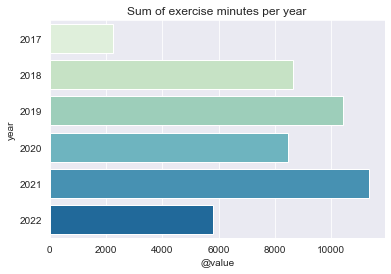

In [201]:
sns.barplot(x='@value',y='year',data=df.groupby('year')['@value'].sum().reset_index(),orient='horizontal',palette='GnBu')#.loc[df.year == 2021])
plt.title('Sum of exercise minutes per year')
plt.savefig('Sum of exercise minutes per year.png',transparent=True)
plt.show()

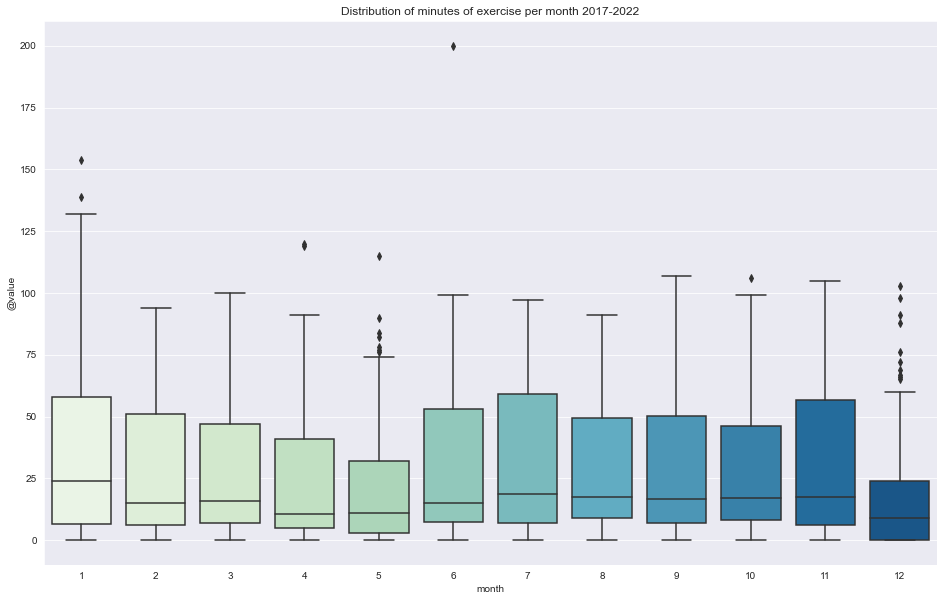

In [206]:
plt.figure(figsize=(16,10))
sns.boxplot(y='@value',x='month',data=df,palette='GnBu')#.loc[df.year == 2021])

plt.title('Distribution of minutes of exercise per month 2017-2022')
plt.savefig('Distribution of minutes of exercise per month 2017-2022.png',transparent=True)
plt.show()

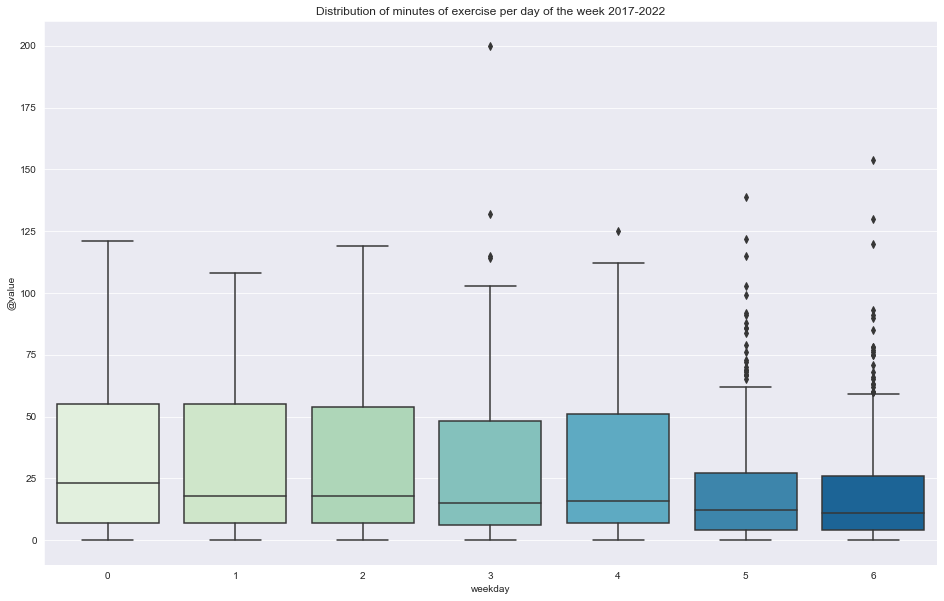

In [209]:
plt.figure(figsize=(16,10))
sns.boxplot(y='@value',x='weekday',data=df,palette='GnBu')#.loc[df.year == 2021])

plt.title('Distribution of minutes of exercise per day of the week 2017-2022')
plt.savefig('Distribution of minutes of exercise per day of the week 2017-2022.png',transparent=True)
plt.show()

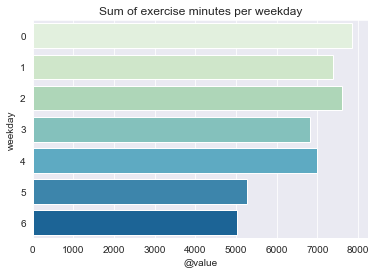

In [211]:
sns.barplot(x='@value',y='weekday',data=df.groupby('weekday')['@value'].sum().reset_index(),orient='horizontal',palette='GnBu')#.loc[df.year == 2021])
plt.title('Sum of exercise minutes per weekday')
plt.savefig('Sum of exercise minutes per weekday.png',transparent=True)
plt.show()

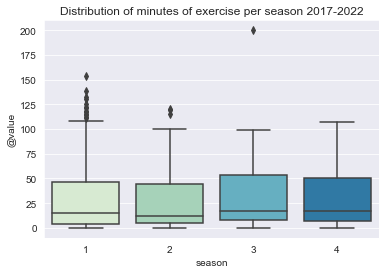

In [214]:
 sns.boxplot(y='@value',x='season',data=df,palette='GnBu')#.loc[df.year == 2021])

plt.title('Distribution of minutes of exercise per season 2017-2022')
plt.savefig('Distribution of minutes of exercise per season 2017-2022.png',transparent=True)
plt.show()

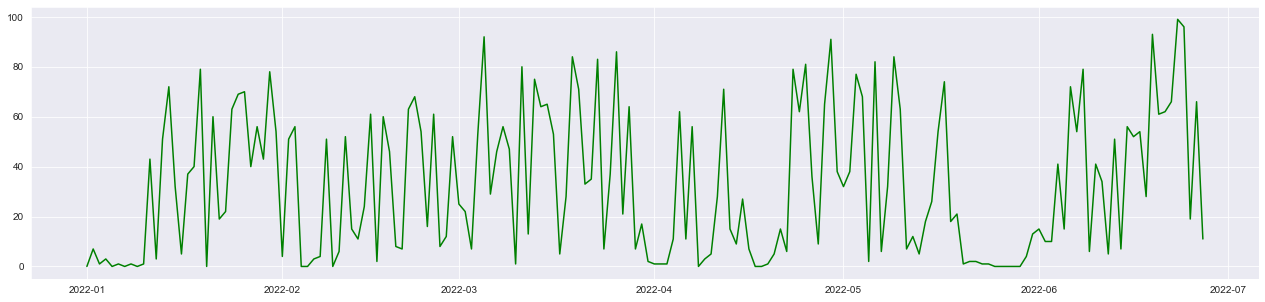

In [186]:
date_form = DateFormatter("%d-%b")

df_plot = df.loc[df.year == 2022]
fig, ax = plt.subplots(figsize=(22, 5))
plt.plot(df_plot.date,df_plot['@value'], label='Real', color='green')

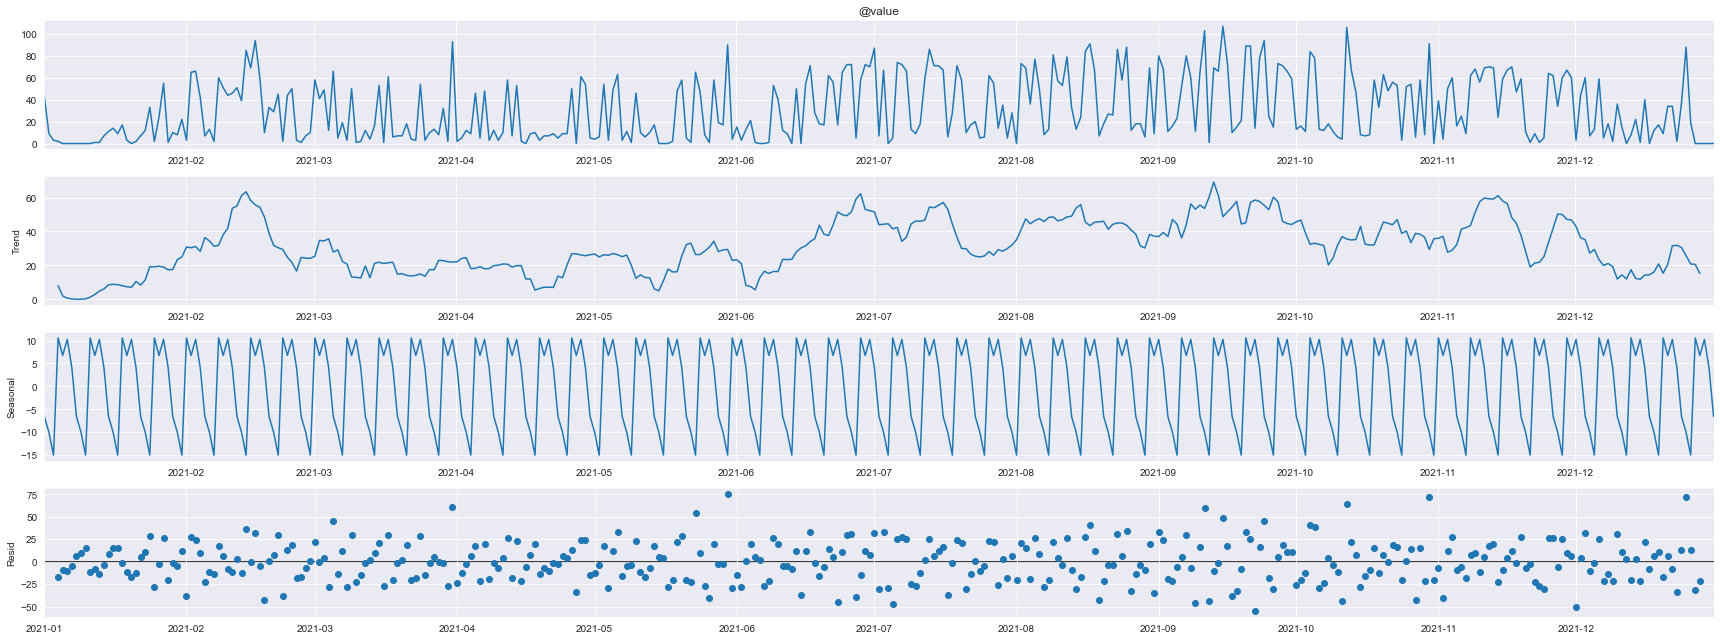

In [216]:
import statsmodels.api as sm
decompose = df.loc[df.year == 2021].copy()
decompose = decompose.sort_values('date').set_index('date')


decomposition = sm.tsa.seasonal_decompose(decompose['@value'], model='additive')
fig = decomposition.plot()
fig.set_size_inches((24, 9))
# Tight layout to realign things
fig.tight_layout()
fig.savefig("decomposition.png",transparent=True)
plt.show()